In [1]:
import sys; sys.path.insert(0, '../')

import torch
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

from gdssm.layers import Mask
from gdssm.networks_toy import Encoder, Dynamics, Decoder
from gdssm.utils import ToyDataset, NLL

In [2]:
cuda_available = torch.cuda.is_available()
if cuda_available:
    device = "cuda:0"
else:
    device = "cpu"

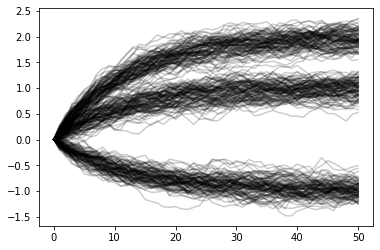

In [3]:
X = np.load("../data/multimodal_toy_dynamics.npy")[:51]
X_test = X[:,[0,1,2,100,101,102,200,201,202]]
plt.plot(X[:,:,0], c="black", alpha=.2);

In [4]:
D_e=5
D_x = 1
num_modes = 4

enc = Encoder(D_e=D_e, D_x=1, num_modes=num_modes).to(device)
dyn = Dynamics(D_x=D_e, dt=1, mode="full").to(device)
dec = Decoder(D_e=D_e, D_x=1, mode="full").to(device)
mask = Mask(mask_type="full", D=D_e, num_nodes=1)
dyn.mask=mask


params = list(dyn.parameters())+list(enc.parameters())+list(dec.parameters())
opt = torch.optim.Adam(params, lr=5e-4)

In [ ]:
best_loss = np.inf
for epoch in range(50):
    dataloader = DataLoader(ToyDataset(X=X.swapaxes(0,1)), batch_size=8, shuffle=True)
    dataloader = iter(dataloader)

    for counter, x in enumerate(dataloader):
        opt.zero_grad()
        x = x.unsqueeze(1).to(device)
        batch_size = x.shape[0]
        A = torch.ones(batch_size, 1, 1).to(device)
        A_modes = torch.ones(batch_size*num_modes, 1, 1).to(device)
        m_enc, P_enc, weights = enc(x[:,:,0,None,:], A)
        m_enc = m_enc.reshape(batch_size*num_modes, 1, D_e)
        P_enc = P_enc.reshape(batch_size*num_modes, 1, D_e, 1, D_e)
                
        horizon =50
        m_dec = []
        P_dec = []
        for h in range(horizon):
            m_enc, P_enc = dyn.next_moments(m_enc, P_enc, A_modes) 
            m_dec_, P_dec_ = dec.next_moments(m_enc, P_enc)
            m_dec.append(m_dec_), P_dec.append(P_dec_)
        m_dec = torch.stack(m_dec)
        P_dec = torch.stack(P_dec)
        m_dec = m_dec.reshape(horizon, batch_size, num_modes, 1).transpose(0,1)
        P_dec = P_dec.reshape(horizon, batch_size, num_modes, 1, 1).transpose(0,1)
        x_modes = x[:,0].unsqueeze(2).repeat(1,1,num_modes, 1)
        nll_mode = NLL(x_modes[:,1:].reshape(-1, 1),
                    m_dec.reshape(-1, 1),
                    P_dec.reshape(-1, 1, 1),
                    jitter=1e-4)
        nll_mode = nll_mode.reshape(batch_size, horizon, num_modes)
        weighted_likelihood = (torch.exp(-nll_mode)*(weights.unsqueeze(1))).sum(2)
        weighted_likelihood = -torch.log(weighted_likelihood+1e-6)
        weighted_likelihood.mean().backward()
        opt.step()
        
        if counter%10==0:
            with torch.no_grad():
                x = torch.FloatTensor(X_test).swapaxes(0,1)
                x = x.unsqueeze(1).to(device)
                batch_size = x.shape[0]
                A = torch.ones(batch_size, 1, 1).to(device)
                A_modes = torch.ones(batch_size*num_modes, 1, 1).to(device)
                m_enc, P_enc, weights = enc(x[:,:,0,None,:], A)
                m_enc = m_enc.reshape(batch_size*num_modes, 1, D_e)
                P_enc = P_enc.reshape(batch_size*num_modes, 1, D_e, 1, D_e)
                        
                horizon =x.shape[2]-1
                m_dec = []
                P_dec = []
                for h in range(horizon):
                    m_enc, P_enc = dyn.next_moments(m_enc, P_enc, A_modes) 
                    m_dec_, P_dec_ = dec.next_moments(m_enc, P_enc)
                    m_dec.append(m_dec_), P_dec.append(P_dec_)
                m_dec = torch.stack(m_dec)
                P_dec = torch.stack(P_dec)
                m_dec = m_dec.reshape(horizon, batch_size, num_modes, 1).transpose(0,1)
                P_dec = P_dec.reshape(horizon, batch_size, num_modes, 1, 1).transpose(0,1)
                x_modes = x[:,0].unsqueeze(2).repeat(1,1,num_modes, 1)
                nll_mode = NLL(x_modes[:,1:].reshape(-1, 1),
                            m_dec.reshape(-1, 1),
                            P_dec.reshape(-1, 1, 1),
                            jitter=1e-4)
                nll_mode = nll_mode.reshape(batch_size, horizon, num_modes)
                weighted_likelihood = (torch.exp(-nll_mode)*(weights.unsqueeze(1))).sum(2)
                weighted_likelihood = -torch.log(weighted_likelihood+1e-6)
                weighted_likelihood = weighted_likelihood.mean()
                if weighted_likelihood < best_loss:
                    best_loss = weighted_likelihood
                    print("New best NLL {:.2f}".format(best_loss))
                    torch.save(dyn.state_dict(), "../weights/dyn")
                    torch.save(enc.state_dict(), "../weights/enc")
                    torch.save(dec.state_dict(), "../weights/dec")

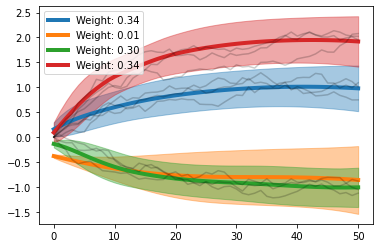

In [5]:
dyn.load_state_dict(torch.load("../weights/dyn"))
dec.load_state_dict(torch.load("../weights/dec"))
enc.load_state_dict(torch.load("../weights/enc"))
A = torch.ones(1, 1, 1).to(device)
A_modes = torch.ones(1*num_modes, 1, 1).to(device)
m_enc, P_enc, weights = enc(torch.zeros(1,1,1,1).to(device), A)
m_enc = m_enc.reshape(1*num_modes, 1, D_e)
P_enc = P_enc.reshape(1*num_modes, 1, D_e, 1, D_e)
        
horizon = 51
m_dec = []
P_dec = []
for h in range(horizon):
    m_enc, P_enc = dyn.next_moments(m_enc, P_enc, A_modes) 
    m_dec_, P_dec_ = dec.next_moments(m_enc, P_enc)
    m_dec.append(m_dec_), P_dec.append(P_dec_)
m_dec = torch.stack(m_dec)
P_dec = torch.stack(P_dec)
m_dec = m_dec.reshape(horizon, num_modes)
P_dec = P_dec.reshape(horizon, num_modes)
    
for m in range(num_modes):
    plt.plot(m_dec[:,m].cpu().detach().numpy(), lw=4, label="Weight: {:.2f}".format(weights[0,m].detach().cpu()))
    plt.fill_between(np.arange(len(m_dec[:,m].detach())), 
                        m_dec[:,m].cpu().detach()+P_dec[:,m].cpu().detach().sqrt()*2, 
                        m_dec[:,m].cpu().detach()-P_dec[:,m].cpu().detach().sqrt()*2,  
                        color="C{}".format(m), alpha=.4,)
plt.legend()
plt.plot(X_test[:,:,0], c="black", alpha=.2);